In [1]:
%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1,'../src')
sys.path.insert(1,'../')

matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']
from __future__ import print_function
import timeit
from ellipsoid import *

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Mixture of two Gaussians

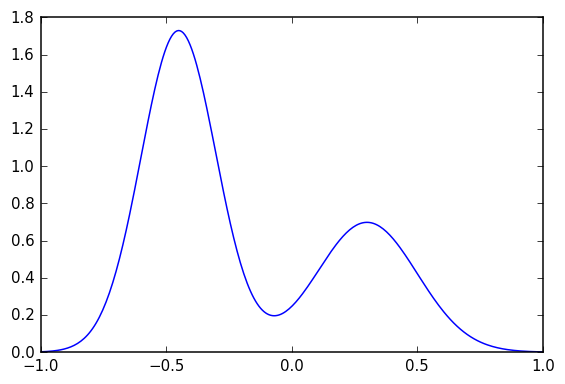

In [2]:
mixture_params = ((.65, -.45, .15), (.35, .3, .2))
gmm = mixture_distribution([normal_distribution(-.45, .15), normal_distribution(.3, .2)], [.65, .35])
fig = plot_distribution(gmm, (-1, 1))

### We draw samples

In [3]:
n = 2000
samples = sorted(gmm.draw_samples(2000))

smin = np.min(samples) - 1e-3
smax = np.max(samples) + 1e-3
print('n = {}  min = {}  max = {}'.format(n, np.min(samples), np.max(samples)))

n = 2000  min = -0.902233774087  max = 0.870871269145


The plot only shows a subset of the samples.

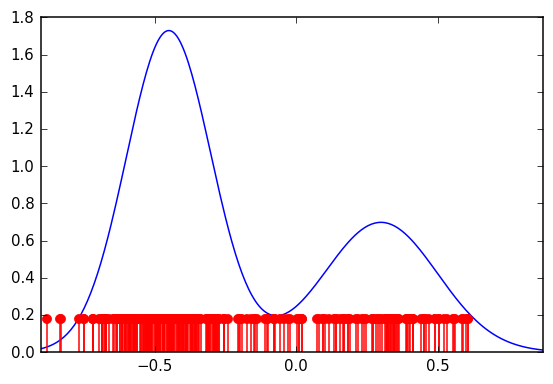

In [4]:
fig = plot_distribution_with_samples(gmm, np.random.choice(samples, 300), (smin, smax))

### Let's run our algorithm

In [5]:
# Number of pieces
t = 4

# Rough estimate of eps to get the number of initial intervals
eps = math.sqrt(2 * t / float(n))
num_initial_intervals = min(n, int(math.ceil(t / eps)))

num_merged_intervals_holdout = t
max_final_num_intervals = 2 * num_merged_intervals_holdout + 1

print('num_initial_intervals = {}  max_final_num_intervals = {}  eps = {}'.format(num_initial_intervals, max_final_num_intervals, eps))

# Parameters for the A1 projections
h = ellipsoid_cpp.LinearPieceVector()
samples_cpp = ellipsoid_cpp.DoubleVector(samples)
opts = ellipsoid_cpp.A1ProjectionOptions()
opts.max_gap = eps / (4.0 * max_final_num_intervals)
opts.max_num_iterations = 20
opts.num_initial_interval_levels = 2
stats = ellipsoid_cpp.A1ProjectionStats()
print('opts.max_gap = {}  opts.max_num_iterations = {}\n'.format(opts.max_gap, opts.max_num_iterations))

# Actually running the algorithm
%timeit ellipsoid_cpp.piecewise_linear_approx(samples_cpp, smin, smax, num_initial_intervals, num_merged_intervals_holdout, max_final_num_intervals, opts, h, stats)
print('\nnum_merging_iterations = {}  num_a1_projections = {}'.format(stats.num_merging_iterations,  stats.num_a1_projections))
print('num_a1_computations = {}  weighted_num_a1_computations = {}'.format(stats.num_a1_computations,  stats.weighted_num_a1_computations))

res = convert_piecewise_linear_to_pp_hypothesis(h)
l1_err = compute_l1_quad(gmm.get_pdf(), get_ppoly_pdf(res), (smin, smax))
print('\nL1 error: {}'.format(l1_err))

num_initial_intervals = 64  max_final_num_intervals = 9  eps = 0.0632455532034
opts.max_gap = 0.00175682092232  opts.max_num_iterations = 20

100 loops, best of 3: 5.11 ms per loop

num_merging_iterations = 6  num_a1_projections = 58773
num_a1_computations = 330  weighted_num_a1_computations = 20.6565

L1 error: 0.109242760502


How many samples do we need to get this accuracy according to our prediction? $\frac{t}{\varepsilon^2}$ is

In [6]:
2 * t / l1_err**2

670.35469440733084

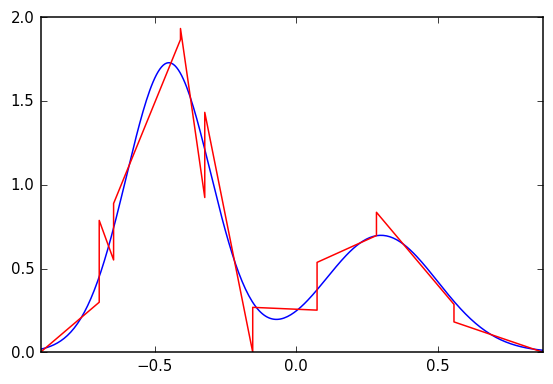

In [7]:
fig = plot_distribution(gmm, (smin, smax))
fig = poly_plot([res], (smin, smax), fig, ['red'])

### Simple postprocessing to make the density estimate continuous

In [51]:
res2 = pp_patch(res, eps / 2.0, samples)
sizes = [ppart.right - ppart.left for ppart in res2]
weights = [ppart.right_sample_index - ppart.left_sample_index for ppart in res2]
print('sizes: {}'.format(sizes))
print('weights: {}'.format(weights))
len(res2)

sizes: [0.29927170711157214, 0.020091372334611224, 0.13128280553621313, 0.017585059403421144, 0.16840849338456537, 0.081652019073374299, 0.040667225715228017, 0.16351929518327818, 0.14631243867035995, 0.049232130563997056, 0.30565535803876431, 0.19163493368683981, 0.4355675750821838]
weights: [111, 38, 196, 38, 222, 38, 13, 38, 62, 38, 162, 38, 6]


13

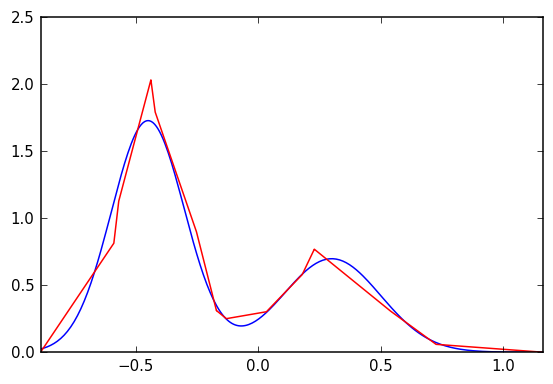

In [52]:
fig = plot_distribution(gmm, (smin, smax))
fig = poly_plot([res2], (smin, smax), fig, ['red'])

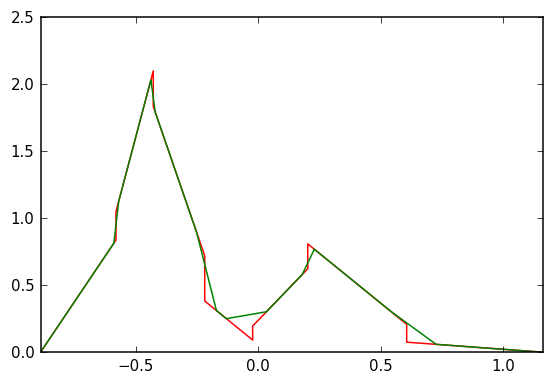

In [53]:
fig = poly_plot([res, res2], (smin, smax), colors=['red', 'green'])

In [48]:
compute_l1_quad(gmm.get_pdf(), get_ppoly_pdf(res), (smin, smax))

0.12468899154624598

In [49]:
compute_l1_quad(gmm.get_pdf(), get_ppoly_pdf(res2), (smin, smax))

0.1152029789348616